# Import Libraries

In [1]:
from datetime import datetime
import torch.nn as nn
import torch
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from kornia.enhance import denormalize
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import segmentation_models_pytorch as smp
from ssl_utils import (train_mae, read_sar_timeseries_data, Dataset, ViT, free_gpu_memory,
                       FinetunerSegmentation, eval_semantic_segmentation, train_semantic_segmentation, visualize_predictions)

# Load the dataset and see an example of a data point

## 1) The KuroSiwo dataset

KuroSiwo is a global, manually annotated multi-temporal SAR flood-mapping dataset. Each sample consists of time-series SAR imagery (dual polarization VV and VH), elevation/DEM information, and flood annotations for supervised tasks. For SSL we also benefit from extra unlabeled samples provided in the dataset.

Key points:
- Multi-temporal SAR with dual polarization (VV, VH) and spatial context.
- Contains labelled flood events but also many unlabeled samples — ideal for self-supervised pretraining.
- We use the dataset for pretraining a Masked Autoencoder (MAE) and then fine-tune the encoder for flood segmentation.





 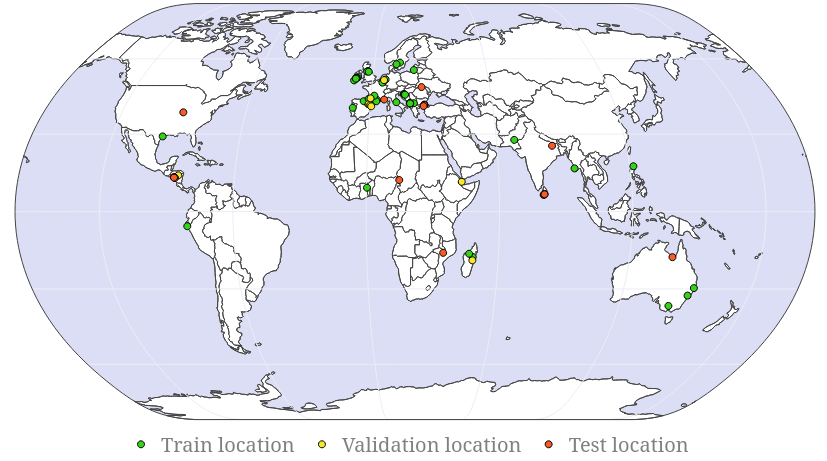


In [ ]:
kuro_siwo_root_path = Path('/home/jovyan/data/MiniKuroSiwo')

Current memory usage: 0.86 GB


## Accessing the data

We have predefined pickle files that contain dictionaries with all necessary information for each data sample, i.e. unique identifier, date and path of each caption, climate zone, bounding box, etc.

Pickle *KuroV2_grid_dict.pkl* contains samples with at least one pixel with some form of water (flooded area or permanent water body). This is primarily used for training.

Pickle *KuroV2_grid_dict_test_0_100.pkl* contains all samples in our AOIs.

Let's open a pickle file and view an entry.

In [ ]:
pkl = pickle.load(open(kuro_siwo_root_path / 'KuroV2_grid_dict_test_0_100.pkl', 'rb'))

Current memory usage: 1.79 GB


In [ ]:
sample_id = "efb6c36380b55b30a5ac053bf11343f7"
pkl[sample_id].keys()

Current memory usage: 1.79 GB


As we can see, an entry contains the following keys:
 - `path`: the base path containing this particular sample
 - `info`: metadata for each image in this sample
 - `clz`: the id of the climate zone this sample belongs to
 - `clz_name`: the name of the climate zone this sample belongs to

In [ ]:
pkl[sample_id]['info']

Current memory usage: 1.79 GB


In `['info']['datasets']` we can see more information on each image. Based on this example we will explain the naming convention:
 - `SL1_IVH_1111013_01_20170422`: the VH channel of the first pre-flood image
 - `SL1_IVV_1111013_01_20170422`: the VV channel of the first pre-flood image
 - `SL2_IVH_1111013_01_20170410`: the VH channel of the second pre-flood image
 - `SL2_IVV_1111013_01_20170410`: the VV channel of the second pre-flood image
 - `MS1_IVH_1111013_01_20170504`: the VH channel of the post-flood image
 - `MS1_IVV_1111013_01_20170504`: the VV channel of the post-flood image
 - `MK0_MNA_1111013_01_20170504`: a binary mask identifying the pixels inside the annotator's AOI
 - `MK0_MLU_1111013_01_20170504`: the label
 - `MK0_DEM_1111013_01_20170504`: a DEM for this particular patch

# Visualisation helper fuction

In [ ]:
%matplotlib inline
def visualize_sample(path):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0), (0.00000, 1.00000, 0.60000, 1.0)], 4)



    flood_vv, flood_vh, sec1_vv, sec1_vh, sec2_vv, sec2_vh, dem, mask, post_date, pre1_date, pre2_date = read_sar_timeseries_data(path)
    fig, axes = plt.subplots(1, 8, figsize=(30, 15), num=1, clear=True)

    axes[0].imshow(sec2_vv,cmap='gray')
    axes[0].set_title('Caption 1 (VV)',fontsize=28)
    axes[0].set_xlabel("Acq. Date: " + str(pre2_date.strftime('%Y-%m-%d')), fontsize=16)

    axes[1].imshow(sec2_vh,cmap='gray',)
    axes[1].set_title('Caption 1 (VH)',fontsize=28)
    axes[1].set_xlabel("Acq. Date: " + str(pre2_date.strftime('%Y-%m-%d')), fontsize=16)


    axes[2].imshow(sec1_vv,cmap='gray')
    axes[2].set_title('Caption 2 (VV)',fontsize=28)
    axes[2].set_xlabel("Acq. Date: " + str(pre1_date.strftime('%Y-%m-%d')), fontsize=16)

    axes[3].imshow(sec1_vh,cmap='gray')
    axes[3].set_title('Caption 2 (VH)',fontsize=28)
    axes[3].set_xlabel("Acq. Date: " + str(pre1_date.strftime('%Y-%m-%d')), fontsize=16)


    axes[ 4].imshow(flood_vv,cmap='gray')
    axes[4].set_title('Post Event (VV)',fontsize=28)
    axes[4].set_xlabel("Acq. Date: " + str(post_date.strftime('%Y-%m-%d')), fontsize=16)

    axes[ 5].imshow(flood_vh,cmap='gray')
    axes[5].set_title('Post Event (VH)',fontsize=28)
    axes[5].set_xlabel("Acq. Date: " + str(post_date.strftime('%Y-%m-%d')), fontsize=16)


    axes[6].imshow(dem.squeeze(),cmap='gray')
    axes[6].set_title('DEM',fontsize=28)

    axes[7].imshow(mask,vmin=0, vmax=3, cmap=cmap)
    axes[7].set_title('Ground truth',fontsize=28)

    # Remove all axis labels
    for irow in range(1):
        for icol in range(8):
            axes[icol].set_xticks([])
            axes[icol].set_yticks([])
            axes[icol].spines['top'].set_visible(False)
            axes[ icol].spines['right'].set_visible(False)
            axes[ icol].spines['bottom'].set_visible(False)
            axes[ icol].spines['left'].set_visible(False)

    fig.tight_layout()
    plt.show()

Current memory usage: 1.79 GB


We visualise a single sample

Notice the two captions before the flood event in different timesteps, the post event and the DEM informations

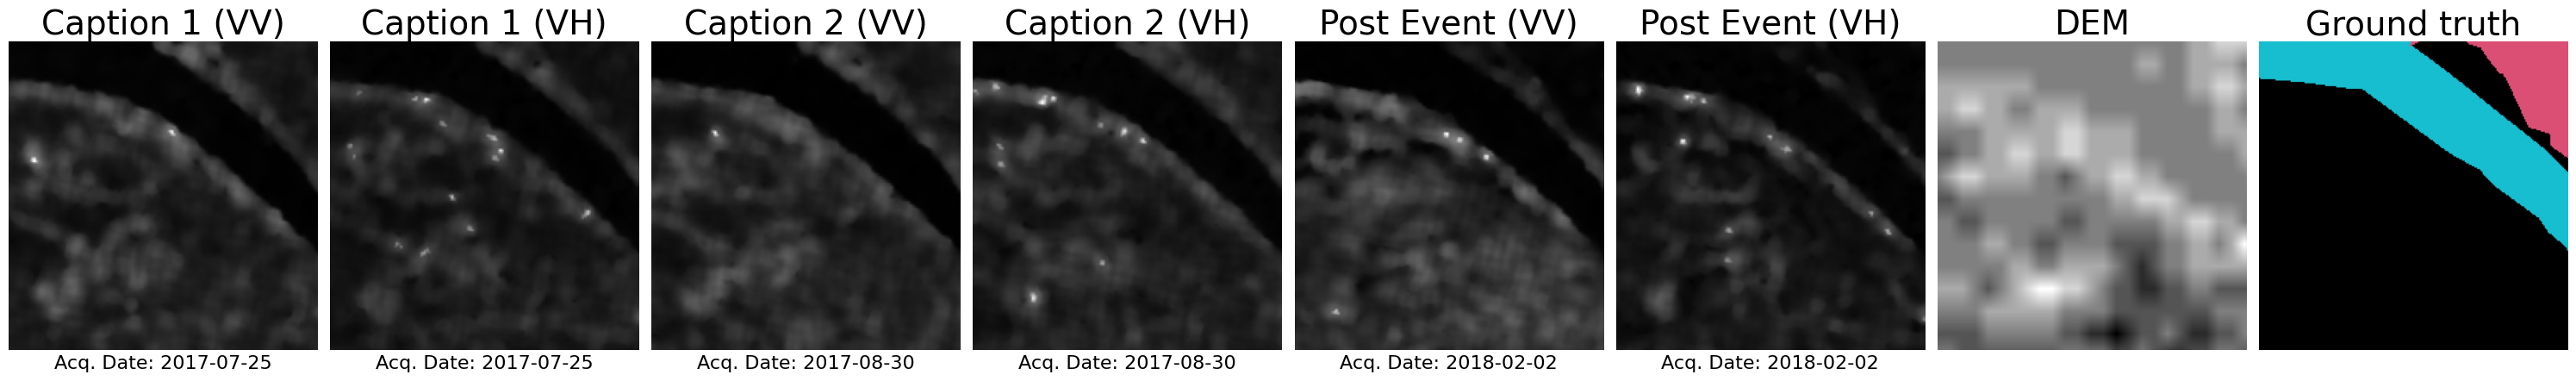

Current memory usage: 1.82 GB


In [ ]:
sample_path = kuro_siwo_root_path / 'data' / pkl[sample_id]['path']
visualize_sample(sample_path)

# Training a DL model for Flood Mapping

We will define a dictionary with the basic configurations for training a simple model.

In [ ]:
configs = {
  "task": "segmentation", # method category, options: segmentation, mae (Masked Autoencoder)
  "root_path": kuro_siwo_root_path / 'data', # your data root path
  "method": "unet", # architecture choice e.g UNet
  "device": "cuda" if torch.cuda.is_available() else "cpu",
  "mixed_precision": False,
  "num_classes": 3,
  "batch_size": 16,
  "epochs": 1,
  "num_workers": 2,
  "print_frequency":10,
  "train_pickle": kuro_siwo_root_path / "KuroV2_grid_dict.pkl",  # path to train pickle
  "test_pickle": kuro_siwo_root_path / "KuroV2_grid_dict_test_0_100.pkl",  # path to test pickle
  "inputs": ["pre_event_1", "pre_event_2", "post_event"], # Timesteps to include in the input
  "channels": [ "vv","vh"], #Polarizations to include in the input
  "clamp_input": 0.15, #Max value for SAR data
  "scale_input": True, # standarize data
  "data_mean": [0.0904, 0.0241],
  "data_std": [0.0468, 0.0226],
  "dem_mean": 93.4313,
  "dem_std": 1410.8382,
  "dem": False, # Option to include DEM
  "slope": False, # Option to inlcude slope
  "slope_mean": 2.1277,
  "slope_std": 67.5048,
  "train_acts": [267,118],
  "val_acts": [562],
  "test_acts": [567]
}

Current memory usage: 1.82 GB


## Data splits

*For the purpose of this tutorial, we will use a small subset of Kuro Siwo in order to reduce time and resource requirements.*

The events in our dataset come from Lithuania (267), Spain (118), Togo (470) and Australia (562, 567)

Our goal is to train a model able to produce a per-pixel mapping of both permanent waters and flooded regions, using as input the SAR timeseries.



## Loading the data

In [ ]:
train_dataset = Dataset(mode="train", configs=configs)
val_dataset = Dataset(mode="val", configs=configs)
test_dataset = Dataset(mode="test", configs=configs)

def create_dataloaders(train_dataset,val_dataset,test_dataset):
	train_loader = torch.utils.data.DataLoader(
			train_dataset,
			batch_size=configs['batch_size'],
			shuffle=True,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=True,
	)

	val_loader = torch.utils.data.DataLoader(
			val_dataset,
			batch_size=configs['batch_size'],
			shuffle=False,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=False,
	)

	test_loader = torch.utils.data.DataLoader(
			test_dataset,
			batch_size=configs['batch_size'],
			shuffle=False,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=False,
	)

	print("Samples in Train Set: ", len(train_loader.dataset))
	print("Samples in Val Set: ", len(val_loader.dataset))
	print("Samples in Test Set: ", len(test_loader.dataset))
	return train_loader, val_loader, test_loader

Samples per Climatic zone for mode:  train
{1: 0, 2: 56, 3: 270}
Samples per Activation for mode:  train
{118: 108, 267: 218}
Samples per Climatic zone for mode:  val
{1: 0, 2: 77, 3: 0}
Samples per Activation for mode:  val
{562: 77}
Samples per Climatic zone for mode:  test
{1: 0, 2: 0, 3: 103}
Samples per Activation for mode:  test
{567: 103}
Current memory usage: 4.10 GB
SURPASSED MEMORY


In [ ]:
train_loader, val_loader, test_loader = create_dataloaders(train_dataset,val_dataset,test_dataset)

Samples in Train Set:  326
Samples in Val Set:  77
Samples in Test Set:  103
Current memory usage: 4.10 GB
SURPASSED MEMORY


## Rapid flood mapping as a semantic segmentation task

As defined in our configurations, our first model will be a U-Net [1], a very popular architecture for semantic segmentation tasks. In this case, we stack the SAR timeseries and feed it to our model.

*[1]: Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18 (pp. 234-241). Springer International Publishing.*

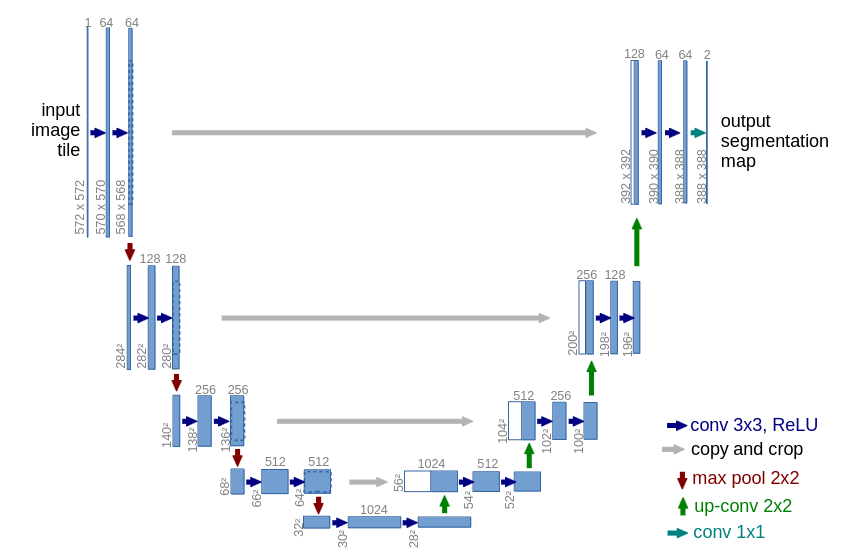


Below we define a dictionary containing a basic configuration for our U-Net. We will use a ResNet-18 as a backbone and we will initialize the model with weights pretrained on ImageNet. The Adam optimizer with a learning rate of `0.001` and cosine learning rate scheduling will be used for training.

In [ ]:
model_configs = {
    "method": "unet",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "weight_decay": 0.0,
    "lr_schedule": "cosine",
    "architecture": "UNet",
    "backbone": "resnet18",
    "pretrained": True,
    "encoder_weights": "imagenet"
}

Current memory usage: 4.10 GB
SURPASSED MEMORY


Let's create the model.

In [ ]:
num_channels = len(configs['channels']) * len(configs['inputs'])
if configs['dem']:
	num_channels += 1

model = smp.Unet(
  encoder_name=model_configs["backbone"],  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
  encoder_weights=model_configs["encoder_weights"],  # use `imagenet` pre-trained weights for encoder initialization
  in_channels=num_channels,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
  classes=configs["num_classes"],  # model output channels (number of classes in your dataset)
)

Current memory usage: 4.16 GB
SURPASSED MEMORY


### Create checkpoint directories

We will define the directory to save our model checkpoints into.

In [ ]:
checkpoint_path =  Path('./checkpoints/UNET')
checkpoint_path.mkdir(parents=True, exist_ok=True)
configs['checkpoint_path'] = checkpoint_path

Current memory usage: 4.16 GB
SURPASSED MEMORY


## Training the model

We will train the model for just one epoch and load a pretrained one afterwards

In [ ]:
# Train the model
train_semantic_segmentation(model, train_loader, val_loader, test_loader, configs=configs, model_configs=model_configs)

In [ ]:
!wget -O ./pretrained_unet.pt https://huggingface.co/luisdio/zerotohero_weights/resolve/main/pretrained_unet.pt

In [ ]:
# Evaluate on Test Set

saved_weights = Path('./pretrained_unet.pt')
print(f"Loading model from: {saved_weights}")
model = torch.load(saved_weights, weights_only=False)

test_acc, test_score, miou = eval_semantic_segmentation(model, test_loader, settype="Test", configs=configs, model_configs=model_configs)
print("Test Mean IOU: ", miou)

Loading model from: /mnt/hdd1/diogenis/ellis_notebooks/pretrained_unet.pt


  0%|          | 0/7 [00:00<?, ?it/s]/mnt/hdd1/diogenis/ellis_notebooks/ssl_utils.py:1322: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Test Loss: 4.500425406864712
Test Accuracy (No water): 95.29182314872742
Test Accuracy (Permanent Waters): 71.63909673690796
Test Accuracy (Floods): 77.17952132225037
Test F-Score (No water): 92.09248423576355
Test F-Score (Permanent Waters): 69.39250230789185
Test F-Score (Floods): 85.03909111022949
Test Precision (No water): 89.1010046005249
Test Precision (Permanent Waters): 67.28253364562988
Test Precision (Floods): 94.68090534210205
Test Recall (No water): 95.29182314872742
Test Recall (Permanent Waters): 71.63909673690796
Test Recall (Floods): 77.17952132225037
Test IoU (No water): 85.34390926361084
Test IoU (Permanent Waters): 53.13056707382202
Test IoU (Floods): 73.97217750549316
Test MeanIoU: 70.81554412841797

Test Mean IOU:  tensor(70.8155)
Current memory usage: 4.67 GB
SURPASSED MEMORY


# Visualize results

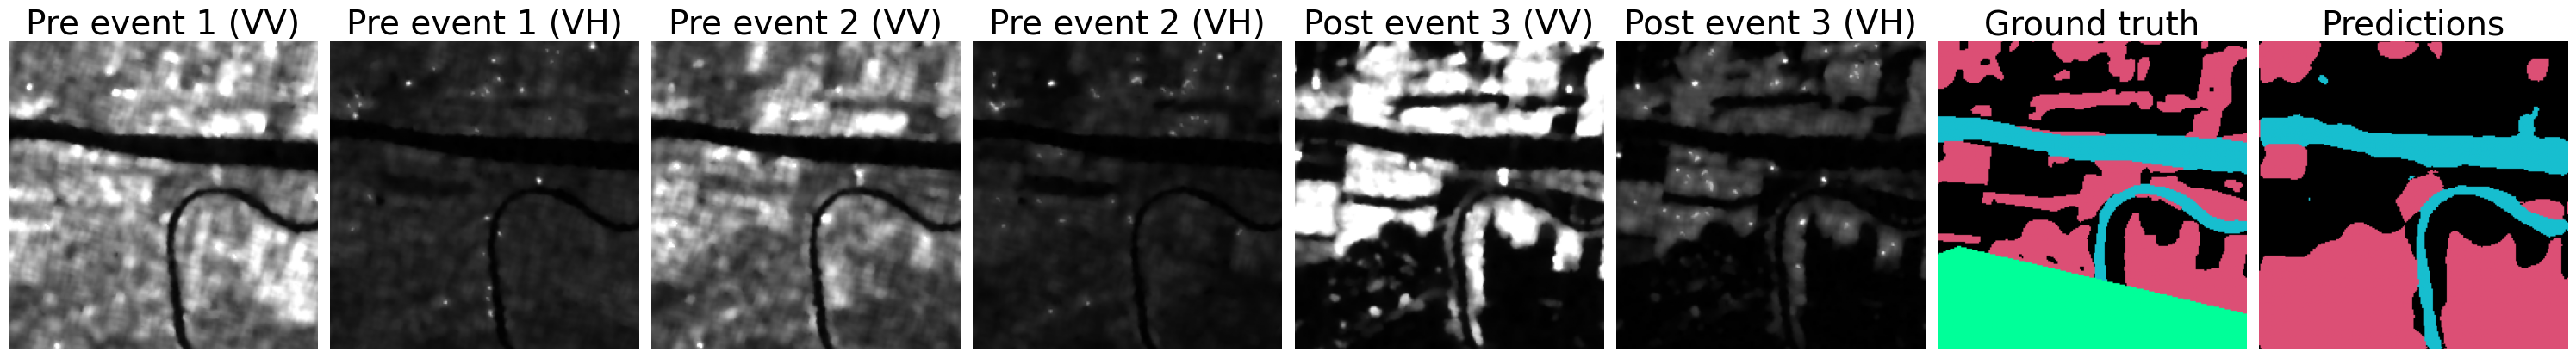

Current memory usage: 4.68 GB
SURPASSED MEMORY


In [ ]:
visualize_predictions(test_dataset,model,configs)

In [ ]:
del model

## 2) Why Self-Supervised Learning (SSL) in Remote Sensing?

Remote sensing datasets often contain **a lot** of unlabeled data: raw satellite acquisitions are abundant, but manual annotations are expensive. SSL allows us to learn useful representations from unlabeled data (pretraining) which can then be fine-tuned with relatively few labels.

Benefits for RS:
- Leverage large amounts of unlabeled SAR/optical data.
- Learn robust features invariant to noise, missing data, seasonal shifts.
- Improve downstream performance (segmentation, change detection, classification) and reduce label requirements.



## 3) Theory: Masked Autoencoders (MAE)

**What is an MAE?**
A Masked Autoencoder randomly masks a large fraction of image patches and trains a lightweight decoder to reconstruct the missing pixels from the remaining visible patches. A Vision Transformer (ViT) encoder processes only the visible patches — this makes the encoder efficient. The encoder is later used for downstream tasks.

**Key ingredients**
- **Patchify** the image into non-overlapping patches (e.g. 16×16).
- **Random masking**: remove a large portion (commonly 50–75%) of patches.
- **Encoder**: a ViT that processes only unmasked patches (faster, forces contextual reasoning).
- **Decoder**: a small transformer that takes encoded visible tokens + mask tokens and reconstructs pixel values for masked patches.
- **Loss**: reconstruction loss (usually MSE) computed only on masked patches.

**Why MAE works for RS (and SAR)?**
- For SAR time-series and multi-polarization signals, local context and temporal context are informative — reconstructing missing patches forces the model to capture spatial/temporal correlations.
- MAE pretraining encourages the encoder to learn representations useful for downstream tasks like flood segmentation.




# Self-supervised learning using Masked Autoencoders

# MAE configurations

Important configuration to notice here is the mask ratio (indicating the percentage of the patches to be masked) and the patch size 

In [ ]:
mae_configs = {
    "image_size":224,
    "patch_size":16,
    "num_classes":1000,
    "dim":1026, # modified to be divisible by 3, initial value: 1024,
    "depth":24,
    "heads":16,
    "mlp_dim":2048,
    "masked_ratio":0.75,
    "decoder_dim":512,
    "decoder_depth":8,
    "decoder_heads":16,
    "num_samples_per_epoch":10,
    "accumulate_gradients":4,
    "warmup_epochs":10,
    "learning_rate":1e-5,
    "min_lr":0,
    "temporal_embedding":True,
}

Current memory usage: 4.68 GB
SURPASSED MEMORY


### Create checkpoint dir

In [ ]:
checkpoint_path =  Path('./checkpoints/FloodMAE')
checkpoint_path.mkdir(parents=True, exist_ok=True)
configs['checkpoint_path'] = checkpoint_path

Current memory usage: 4.68 GB
SURPASSED MEMORY


# Train MAE

We train the Masked Auto encoder using a simple Means Square Error Loss between the predicted values of the hidden patches with the original values.
For time's sake we will only train for two epochs and load a pretrained model

In [ ]:
train_mae(configs, mae_configs)

# Finetune the encoder for the downstream task

After the pre train, we keep only the encoder for the downstream task and we finetune it.
We attach a decoder on the learnt representations and proceed with the semantic segmentation training

Set up finetuning configurations

In [ ]:
finetuning_configs = {
    "finetuning_patch_size":16,
    "backbone":"vit",
    "architecture":"floodvit",
    "learning_rate": 0.0001,
    "linear_eval":False,
    "weight_decay":1e-3,
    "decoder":True,
    "lr_schedule": "cosine",
    "temporal_embedding":True,
    "num_finetuning_layers":4 #Number of layers to finetune
}

configs = {
  "task": "segmentation", # method category, options: segmentation, mae (Masked Autoencoder)
  "root_path": kuro_siwo_root_path / "data", # your data root path
  "method": "finetune", # architecture choice e.g UNet
  "device": "cuda" if torch.cuda.is_available() else "cpu",
  "mixed_precision": False,
  "num_classes": 3,
  "batch_size": 4,
  "epochs": 1,
  "num_workers": 2,
  "print_frequency":10,
  "train_pickle": kuro_siwo_root_path / "KuroV2_grid_dict.pkl",  # path to train pickle
  "test_pickle": kuro_siwo_root_path / "KuroV2_grid_dict_test_0_100.pkl",  # path to test pickle
  "inputs": ["pre_event_1", "pre_event_2", "post_event"], # Timesteps to include in the input
  "channels": [ "vv","vh"], #Polarizations to include in the input
  "clamp_input": 0.15, #Max value for SAR data
  "scale_input": True, # standarize data
  "data_mean": [0.0904, 0.0241],
  "data_std": [0.0468, 0.0226],
  "dem_mean": 93.4313,
  "dem_std": 1410.8382,
  "dem": False, # Option to include DEM
  "slope": False, # Option to inlcude slope
  "slope_mean": 2.1277,
  "slope_std": 67.5048,
  "train_acts": [267,118],
  "val_acts": [562,470],
  "test_acts": [567]
}

model_configs = {"learning_rate":0.001}
configs.update(finetuning_configs)
configs.update(model_configs)

Current memory usage: 4.68 GB
SURPASSED MEMORY


Path with the weights of the already pretrained encoder

In [ ]:
pretrained_path = kuro_siwo_root_path / "FloodViT" / "floodvit_state_dict.pth"

Current memory usage: 4.68 GB
SURPASSED MEMORY


Notice how we only create a ViT encoder (we dont need the MAE decoder for the downstream task) and we load the pretrained weights

In [ ]:
configs.update(mae_configs)

num_channels = len(configs['channels']) * len(configs['inputs'])
configs['num_channels']=num_channels

encoder = ViT(
        image_size=configs["image_size"],
        patch_size=configs["patch_size"],
        channels=configs["num_channels"],
        num_classes=configs["num_classes"],
        dim=configs["dim"],
        depth=configs["depth"],
        heads=configs["heads"],
        mlp_dim=configs["mlp_dim"],
        temporal_embedding=configs["temporal_embedding"],
        input_length=len(configs["inputs"]),
    )

encoder.load_state_dict(torch.load(pretrained_path))

for param in encoder.parameters():
    param.requires_grad = not configs["linear_eval"]

if not configs["linear_eval"]:
    for param in encoder.parameters():
        param.requires_grad = False

    for param in encoder.transformer.layers[-configs['num_finetuning_layers']:].parameters():
        param.requires_grad = True

Temporal embedding is enabled
Current memory usage: 5.22 GB
SURPASSED MEMORY


## Fuctions to create dataloaders

In [ ]:
def create_dataloaders(train_dataset,val_dataset,test_dataset):
	train_loader = torch.utils.data.DataLoader(
			train_dataset,
			batch_size=configs['batch_size'],
			shuffle=True,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=True,
	)

	val_loader = torch.utils.data.DataLoader(
			val_dataset,
			batch_size=configs['batch_size'],
			shuffle=False,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=False,
	)

	test_loader = torch.utils.data.DataLoader(
			test_dataset,
			batch_size=configs['batch_size'],
			shuffle=False,
			num_workers=configs['num_workers'],
			pin_memory=True,
			drop_last=False,
	)

	print("Samples in Train Set: ", len(train_loader.dataset))
	print("Samples in Val Set: ", len(val_loader.dataset))
	print("Samples in Test Set: ", len(test_loader.dataset))
	return train_loader, val_loader, test_loader

Current memory usage: 5.22 GB
SURPASSED MEMORY


# Prepare datasets

Here we create the datasets we will use to train and test our model in the downstream task

In [ ]:
train_dataset = Dataset(mode="train", configs=configs)
val_dataset = Dataset(mode="val", configs=configs)
test_dataset = Dataset(mode="test", configs=configs)
train_loader, val_loader, test_loader = create_dataloaders(train_dataset,val_dataset,test_dataset)

Samples per Climatic zone for mode:  train
{1: 0, 2: 56, 3: 270}
Samples per Activation for mode:  train
{118: 108, 267: 218}
Samples per Climatic zone for mode:  val
{1: 821, 2: 77, 3: 0}
Samples per Activation for mode:  val
{470: 821, 562: 77}
Samples per Climatic zone for mode:  test
{1: 0, 2: 0, 3: 103}
Samples per Activation for mode:  test
{567: 103}
Samples in Train Set:  326
Samples in Val Set:  898
Samples in Test Set:  103
Current memory usage: 5.25 GB
SURPASSED MEMORY


Create directory for checkpoints during training

In [ ]:
checkpoint_path =  Path('./checkpoints/FloodViTFinetune')
checkpoint_path.mkdir(parents=True, exist_ok=True)
configs['checkpoint_path'] = checkpoint_path

Current memory usage: 5.25 GB
SURPASSED MEMORY


# Finetune

Create the segmentation model, which is the pretrained ViT with a semantic segmentation header

In [ ]:
model = FinetunerSegmentation(encoder=encoder, configs=configs)

Current memory usage: 5.38 GB
SURPASSED MEMORY


In [ ]:
model

Current memory usage: 5.38 GB
SURPASSED MEMORY


## Two ways to finetune a model

### Freeze the learned parameters

The first way to finetune a pretrained model is to freeze the learned representations and train only the header

In [ ]:
# Freeze the encoder (ViT part)
for param in model.model.parameters():   # model.model is the ViT
    param.requires_grad = False

# Make sure decoder (head) is trainable
for param in model.head.parameters():
    param.requires_grad = True

Current memory usage: 5.38 GB
SURPASSED MEMORY


As we can see the only learnable parameters are those of the header

In [ ]:
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(" ", name)

Trainable parameters:
  head.deconv1.weight
  head.deconv1.bias
  head.deconv21.weight
  head.deconv21.bias
  head.deconv2.weight
  head.deconv2.bias
  head.deconv3.weight
  head.deconv3.bias
Current memory usage: 5.38 GB
SURPASSED MEMORY


Fuction to finetune the model. We will only train for one epoch and load an already finetinuned model

In [ ]:
train_semantic_segmentation(model, train_loader, val_loader, test_loader, configs=configs, model_configs=model_configs)

Load an already finetuned model

In [ ]:
saved_weights = Path('./pretrained_prob_vit.pt')
print(f"Loading model from: {saved_weights}")
model = torch.load(saved_weights, weights_only=False)
model.eval()

Loading model from: /mnt/hdd1/diogenis/ellis_notebooks/pretrained_prob_vit.pt
Current memory usage: 5.61 GB
SURPASSED MEMORY


# Visualise the predictions

Finally we visualise a random data point and the prediction

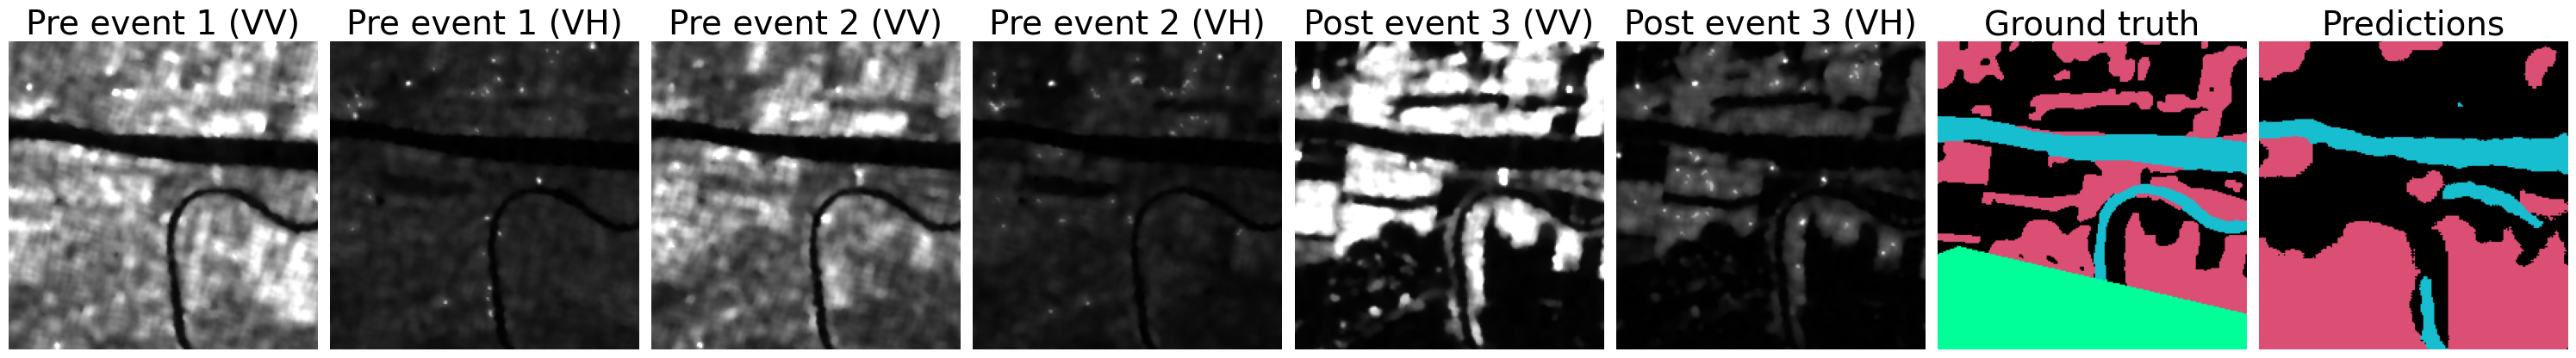

Current memory usage: 6.32 GB
SURPASSED MEMORY


In [ ]:
visualize_predictions(test_dataset,model,configs)

And we test our model in the test set

In [ ]:
test_acc, test_score, miou = eval_semantic_segmentation(model, test_loader, settype="Test", configs=configs, model_configs=model_configs)
print("Test Mean IOU: ", miou)

100%|██████████| 26/26 [01:06<00:00,  2.54s/it]


Test Loss: 1.308193950698926
Test Accuracy (No water): 95.3420341014862
Test Accuracy (Permanent Waters): 91.58982634544373
Test Accuracy (Floods): 75.87476372718811
Test F-Score (No water): 92.72351264953613
Test F-Score (Permanent Waters): 84.43180918693542
Test F-Score (Floods): 83.57230424880981
Test Precision (No water): 90.24497270584106
Test Precision (Permanent Waters): 78.31152677536011
Test Precision (Floods): 93.0080235004425
Test Recall (No water): 95.3420341014862
Test Recall (Permanent Waters): 91.58982634544373
Test Recall (Floods): 75.87476372718811
Test IoU (No water): 86.43413782119751
Test IoU (Permanent Waters): 73.05799722671509
Test IoU (Floods): 71.78043127059937
Test MeanIoU: 77.09085083007812

Test Mean IOU:  tensor(77.0909)
Current memory usage: 6.39 GB
SURPASSED MEMORY


### End to end training

A second way to finetune a pretrained model is to perform end to end finetuning. Meaning we dont freeze any parameters

In [ ]:
encoder = ViT(
        image_size=configs["image_size"],
        patch_size=configs["patch_size"],
        channels=configs["num_channels"],
        num_classes=configs["num_classes"],
        dim=configs["dim"],
        depth=configs["depth"],
        heads=configs["heads"],
        mlp_dim=configs["mlp_dim"],
        temporal_embedding=configs["temporal_embedding"],
        input_length=len(configs["inputs"]),
    )

encoder.load_state_dict(torch.load(pretrained_path))

for param in encoder.parameters():
    param.requires_grad = not configs["linear_eval"]

if not configs["linear_eval"]:
    for param in encoder.parameters():
        param.requires_grad = False

    for param in encoder.transformer.layers[-configs['num_finetuning_layers']:].parameters():
        param.requires_grad = True

Temporal embedding is enabled
Current memory usage: 7.07 GB
SURPASSED MEMORY


Create the segmentation model again but this time dont freeze any weights

In [ ]:
model = FinetunerSegmentation(encoder=encoder, configs=configs)

Current memory usage: 6.98 GB
SURPASSED MEMORY


In [ ]:
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(" ", name)

Trainable parameters:
  model.transformer.layers.20.0.norm.weight
  model.transformer.layers.20.0.norm.bias
  model.transformer.layers.20.0.to_qkv.weight
  model.transformer.layers.20.0.to_out.0.weight
  model.transformer.layers.20.0.to_out.0.bias
  model.transformer.layers.20.1.net.0.weight
  model.transformer.layers.20.1.net.0.bias
  model.transformer.layers.20.1.net.1.weight
  model.transformer.layers.20.1.net.1.bias
  model.transformer.layers.20.1.net.4.weight
  model.transformer.layers.20.1.net.4.bias
  model.transformer.layers.21.0.norm.weight
  model.transformer.layers.21.0.norm.bias
  model.transformer.layers.21.0.to_qkv.weight
  model.transformer.layers.21.0.to_out.0.weight
  model.transformer.layers.21.0.to_out.0.bias
  model.transformer.layers.21.1.net.0.weight
  model.transformer.layers.21.1.net.0.bias
  model.transformer.layers.21.1.net.1.weight
  model.transformer.layers.21.1.net.1.bias
  model.transformer.layers.21.1.net.4.weight
  model.transformer.layers.21.1.net.4.bia

Again, we train the model for just one epoch and we load an already trained model afterwards

In [ ]:
# If this takes too long we can skip this or interrupt it
train_semantic_segmentation(model, train_loader, val_loader, test_loader, configs=configs, model_configs=model_configs)

In [ ]:
saved_weights = Path('./pretrained_finetuned_vit.pt')
print(f"Loading model from: {saved_weights}")
model = torch.load(saved_weights, weights_only=False)
model.eval()

Loading model from: /mnt/hdd1/diogenis/ellis_notebooks/pretrained_finetuned_vit.pt
Current memory usage: 6.98 GB
SURPASSED MEMORY


Visualize a prediction and test the model in the test set

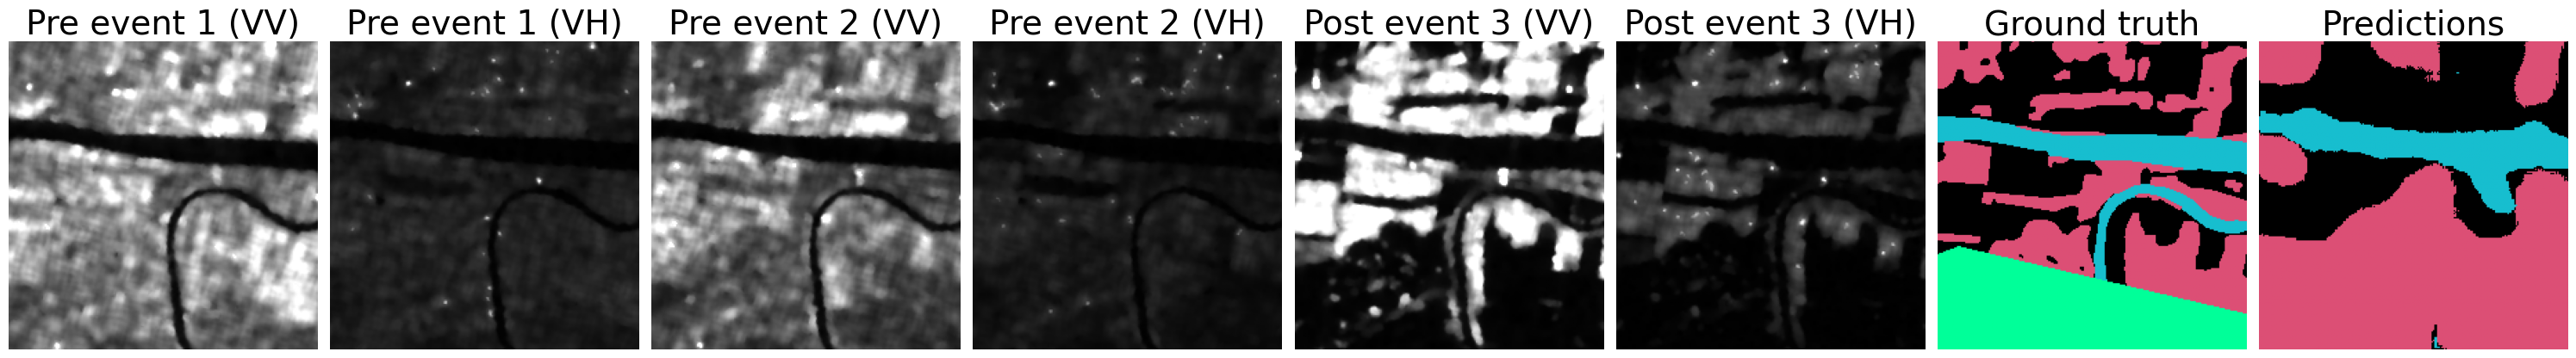

Current memory usage: 6.98 GB
SURPASSED MEMORY


In [ ]:
visualize_predictions(test_dataset,model,configs)

In [ ]:
test_acc, test_score, miou = eval_semantic_segmentation(model, test_loader, settype="Test", configs=configs, model_configs=model_configs)
print("Test Mean IOU: ", miou)

100%|██████████| 26/26 [01:06<00:00,  2.57s/it]


Test Loss: 1.144000639136021
Test Accuracy (No water): 90.98080396652222
Test Accuracy (Permanent Waters): 90.38547277450562
Test Accuracy (Floods): 85.09941697120667
Test F-Score (No water): 92.38121509552002
Test F-Score (Permanent Waters): 81.52602910995483
Test F-Score (Floods): 84.70388650894165
Test Precision (No water): 93.82540583610535
Test Precision (Permanent Waters): 74.24833178520203
Test Precision (Floods): 84.31201577186584
Test Recall (No water): 90.98080396652222
Test Recall (Permanent Waters): 90.38547277450562
Test Recall (Floods): 85.09941697120667
Test IoU (No water): 85.84115505218506
Test IoU (Permanent Waters): 68.81345510482788
Test IoU (Floods): 73.46638441085815
Test MeanIoU: 76.04033660888672

Test Mean IOU:  tensor(76.0403)
Current memory usage: 6.98 GB
SURPASSED MEMORY


So we tried three different models.
- Unet
- A pretrained frozen ViT
- A pretrained ViT with end-to-end finetune

| Model          | Mean IoU |
|----------------|----------|
| U-Net          | 70.82    |
| Frozen ViT     | 77.09    |
| ViT            | 76.04    |

| Unet    | Frozen ViT   | ViT     |
|---------|--------------|---------|
| ![Model A](unet.png) | ![Model B](Frozen.png) | ![Model C](ViT.png) |
